First we have to download and install the pip package

In [40]:
import numpy as np
import torch.nn as nn
from ncps.wirings import AutoNCP 
from ncps.torch import LTC
import pytorch_lightning as pl
import torch
import torch.utils.data as data
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd



In [ ]:
!nvidia-smi

Tue May 16 16:48:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100S-PCI...  On   | 00000000:81:00.0 Off |                    0 |
| N/A   32C    P0    36W / 250W |    310MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [41]:
import datetime as dt
def load_bikes(predict_hour=1):
    df = pd.read_csv("/d/hpc/home/ld8435/liquid_time_constant_networks/experiments_with_ltcs/data/bicikelj/bicikelj_one.csv")

    #parse timestamp
    





    #holiday = (df["holiday"].values == None).astype(np.float32)
    temp = df["temp_c"].values.astype(np.float32)
    temp -= np.mean(temp)  # normalize temp by annual mean
    rain = df["will_it_rain"].values.astype(np.float32)
    #snow = df["snow_1h"].values.astype(np.float32)
    clouds = df["cloud"].values.astype(np.float32)
    date_time = df["date"].values
    # 2012-10-02 13:00:00
    date_time = [dt.datetime.strptime(d, "%Y-%m-%d %H:%M:%S") for d in date_time]
    weekday = np.array([d.weekday() for d in date_time]).astype(np.float32)
    noon = np.array([d.hour for d in date_time]).astype(np.float32)
    noon = np.sin(noon * np.pi / 24)

    hour_of_day = np.array([d.hour for d in date_time]).astype(np.float32)
    day_of_week = np.array([d.weekday() for d in date_time]).astype(np.float32)

    bikes_plus_120mins = df["bikes_plus_120mins"].values.astype(np.float32)
    bikes_plus_60mins = df["bikes_plus_60mins"].values.astype(np.float32)


    traffic_volume = df["value"].values.astype(np.float32)

    prev_hour_bikes = np.zeros_like(traffic_volume)
    prev_hour_bikes[1:] = traffic_volume[:-1]
    prev_hour_bikes[0] = traffic_volume[0]



    features = np.stack([temp, rain, clouds, weekday, hour_of_day,day_of_week,prev_hour_bikes,traffic_volume], axis=-1)

    # traffic_volume -= np.mean(traffic_volume)  # normalize
    # traffic_volume /= np.std(traffic_volume)  # normalize

    #return date_time,features, traffic_volume
    if predict_hour == 1:
        return date_time,features, bikes_plus_60mins

    elif predict_hour == 2:
        return date_time,features, bikes_plus_120mins


def cut_in_sequences(x, y, seq_len, inc=1):

    sequences_x = []
    sequences_y = []

    for s in range(0, x.shape[0] - seq_len, inc):
        start = s
        end = start + seq_len
        sequences_x.append(x[start:end])
        sequences_y.append(y[start:end])

    return np.stack(sequences_x, axis=1), np.stack(sequences_y, axis=1)





In [42]:
from torch.utils.data import Dataset, DataLoader
import datetime as dt

class TrafficDataset(Dataset):
    def __init__(self, seq_len=32, exclude_timestamps=None, predict_hour=1):
        date_time, x, y = load_bikes(predict_hour=predict_hour)
        date_time = np.array(date_time)
        x = np.array(x)
        y = np.array(y)

        print("x.shape", x.shape)
        print("y.shape", y.shape)

        if exclude_timestamps is not None:
            exclude_timestamps = [dt.datetime.strptime(ts, "%Y-%m-%d %H:%M:%S") for ts in exclude_timestamps]
            indices_to_keep = [i for i, dt in enumerate(date_time) if dt not in exclude_timestamps]
            date_time = date_time[indices_to_keep]
            x = x[indices_to_keep]
            y = y[indices_to_keep]

        self.x, self.y = cut_in_sequences(x, y, seq_len, inc=1)

    def __len__(self):
        return self.x.shape[1]

    def __getitem__(self, idx):
        
        return self.x[:, idx], self.y[:, idx].reshape(-1, 1)


For the training we will use Pytorch-Lightning, thus we have to define our learner module. 

In [43]:
# LightningModule for training a RNNSequence module
class SequenceLearner(pl.LightningModule):
    def __init__(self, model, lr=0.005):
        super().__init__()
        self.model = model
        self.lr = lr

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        #mae
        self.log("train_mae", nn.L1Loss()(y_hat, y), prog_bar=True)
        #rmse
        self.log("train_rmse", torch.sqrt(nn.MSELoss()(y_hat, y)), prog_bar=True)
        
        return {"loss": loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)

        self.log("val_loss", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        # Here we just reuse the validation_step for testing
        return self.validation_step(batch, batch_idx)

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)


Next we define some toy dataset and create the corresponding DataLoaders

x.shape (7738, 8)
y.shape (7738,)


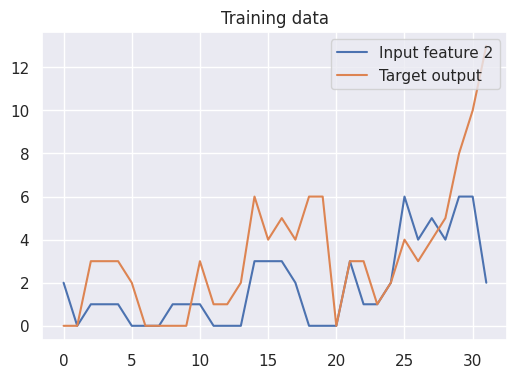

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import DataLoader

# Instantiate the TrafficDataset
dataset = TrafficDataset(seq_len=32, exclude_timestamps=None, predict_hour=1)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)

# Get a batch of data
data_x, data_y = next(iter(dataloader))

# Calculate the sizes of the train, validation, and test sets
train_size = int(0.5 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split the dataset into train, validation, and test sets
train_data, val_data, test_data = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders for train, validation, and test sets
train_dataloader = DataLoader(train_data, batch_size=16, shuffle=True, num_workers=8)
val_dataloader = DataLoader(val_data, batch_size=8, shuffle=False, num_workers=8)
test_dataloader = DataLoader(test_data, batch_size=8, shuffle=False, num_workers=0)


# Example usage of the train, validation, and test DataLoaders
train_batch_x, train_batch_y = next(iter(train_dataloader))
val_batch_x, val_batch_y = next(iter(val_dataloader))
test_batch_x, test_batch_y = next(iter(test_dataloader))

# Convert to torch.Tensor
data_x = torch.Tensor(data_x)
data_y = torch.Tensor(data_y)

# Let's visualize the training data
sns.set()
plt.figure(figsize=(6, 4))

# The visualization might change depending on the structure of your data
# Here, I'm assuming your data has two features and one target variable.
# Modify accordingly if your data structure is different.
plt.plot(data_x[0, :, 7], label="Input feature 2")
plt.plot(data_y[0, :,0], label="Target output")

plt.title("Training data")
plt.legend(loc="upper right")
plt.show()


In [51]:
print("train_batch_x.shape", train_batch_x.shape)

train_batch_x.shape torch.Size([16, 32, 8])


Here we can finally create a LTCCell and make use of the predefined sparse wiring structures of the keras-ncp package. For simplicity we will just define a fully-connected RNN

In [55]:
wiring = AutoNCP(32, 1)  # 16 units, 1 motor neuron

ltc_model = LTC(8, wiring, batch_first=True)
learn = SequenceLearner(ltc_model, lr=0.01)
trainer = pl.Trainer(
    logger=pl.loggers.CSVLogger("log"),
    max_epochs=100,
    gradient_clip_val=1,  # Clip gradient to stabilize training
    devices=1,  # Use GPU
    accelerator='gpu',
    log_every_n_steps=1,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


alloc!


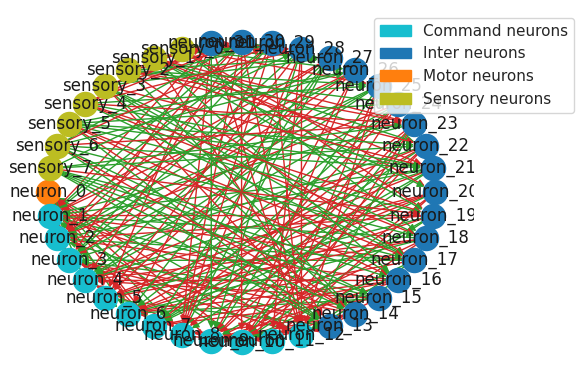

In [54]:
sns.set_style("white")
plt.figure(figsize=(6, 4))
legend_handles = wiring.draw_graph(draw_labels=True,  neuron_colors={"command": "tab:cyan"})
plt.legend(handles=legend_handles, loc="upper center", bbox_to_anchor=(1, 1))
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

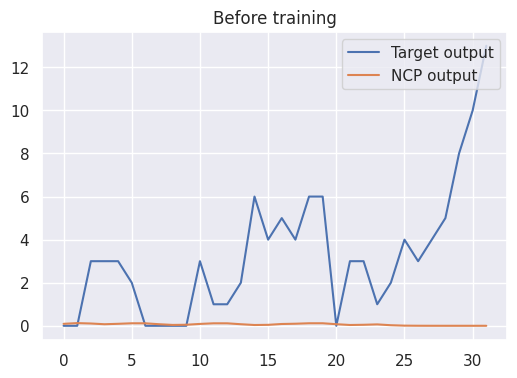

In [56]:
sns.set()
with torch.no_grad():
  prediction = ltc_model(data_x)[0].numpy()
plt.figure(figsize=(6, 4))
plt.plot(data_y[0, :, 0], label="Target output")
plt.plot(prediction[0, :, 0], label="NCP output")

plt.title("Before training")
plt.legend(loc="upper right")
plt.show()

... and train our network 

In [57]:
trainer.fit(learn, train_dataloader, val_dataloader)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | LTC  | 6.5 K 
-------------------------------
5.2 K     Trainable params
1.3 K     Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
/d/hpc/home/ld8435/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/lightning_fabric/loggers/csv_logs.py:188: UserWarning: Experiment logs directory log/lightning_logs/version_0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  rank_zero_warn(


Epoch 99: 100%|████████████████████| 241/241 [01:59<00:00,  2.01it/s, v_num=0, train_loss=14.30, train_mae=2.760, train_rmse=3.780, val_loss=12.10]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|████████████████████| 241/241 [01:59<00:00,  2.01it/s, v_num=0, train_loss=14.30, train_mae=2.760, train_rmse=3.780, val_loss=12.10]


In [12]:
results = trainer.test(learn, test_dataloader)

/Users/carbs/miniforge3/envs/ai/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:478: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │   0.0009687364799901843   │
└───────────────────────────┴───────────────────────────┘

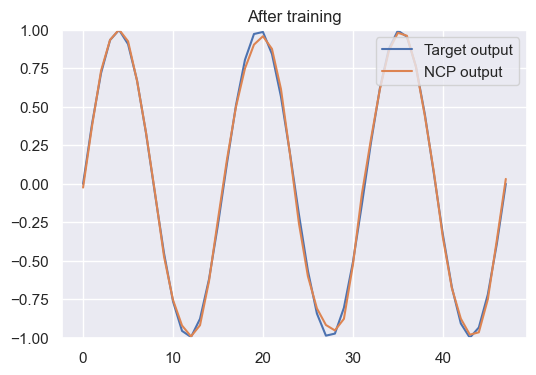

In [13]:
sns.set()
with torch.no_grad():
  prediction = ltc_model(data_x)[0].numpy()
plt.figure(figsize=(6, 4))
plt.plot(data_y[0, :, 0], label="Target output")
plt.plot(prediction[0, :, 0], label="NCP output")
plt.ylim((-1, 1))
plt.title("After training")
plt.legend(loc="upper right")
plt.show()